In [ ]:
!unzip /content/drive/MyDrive/APS360Project/archive/cropped_dataset/A.zip

In [2]:
# initialization
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd
from matplotlib.image import imread
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Mounted at /content/drive


In [4]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [5]:
print(len(total_info['image_id']))
print(len(train_info['image_id']), len(train_info['image_id'])/len(total_info['image_id']))
print(len(val_info['image_id']), len(val_info['image_id'])/len(total_info['image_id']))
print(len(test_info['image_id']), len(test_info['image_id'])/len(total_info['image_id']))

12848
9616 0.7484433374844334
1616 0.12577833125778332
1616 0.12577833125778332


In [6]:
classes = pd.read_csv(class_dict_path)
list(classes['name'])

['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']

In [7]:
class DataFull(object):  # Class names typically use CamelCase
    def __init__(self, csv_info, image_folder_path, transform_input, transform_output):
        self.img_info = csv_info
        self.image_folder_path = image_folder_path
        self.transform_input = transform_input
        self.transform_output = transform_output

    def __len__(self):
        return len(self.img_info)  # Assuming img_info is a DataFrame or similar structure

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][idx])
        image = read_image(img_path)
        label_path = os.path.join(self.image_folder_path, self.img_info['mask_path'][idx])
        label = read_image(label_path)
        if self.transform_input:
            image = self.transform_input(image)
        if self.transform_output:
            label = self.transform_output(label)
        return image, label

In [8]:
mean= [0.4112, 0.3803, 0.2822]
std= [0.1094, 0.0850, 0.0718]
# tensor([0.4112, 0.3803, 0.2822]) tensor([0.1094, 0.0849, 0.0718])

transform_input = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Normalize(mean, std),
         transforms.Resize((256,256))])

transform_output = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Resize((256,256))])

train_dataset = DataFull(train_info, image_folder_path, transform_input, transform_output)
val_dataset = DataFull(val_info, image_folder_path, transform_input, transform_output)
test_dataset = DataFull(test_info, image_folder_path,transform_input, transform_output)

In [ ]:
train_set = []
val_set = []
test_set = []

for i in range(int(len(train_info))):  # Assuming train_dataset is an instance of DataFull
    image, label = train_dataset[i]  # Use subscript notation
    train_set.append((image, label))
    print(i)
print("finish train set")

for i in range(int(len(val_info))):
  image, label = val_dataset[i]
  val_set.append((image, label))
print("finish val set")

for i in range(int(len(test_info))):
  image, label = test_dataset[i]
  test_set.append((image, label))
print("finish test set")

In [ ]:
print(train_set[0])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
k = 0
for i, data in enumerate(train_loader, 0):
    k = k+1
    inputs, labels = data
    print(inputs, labels)
    if k == 1:
        break

In [12]:
def model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


In [13]:
def train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device):
    autoencoder.to(device)
    autoencoder.train()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("Training Start:")
    start_time = time.time()
    for epoch in range(num_epochs):
        # Training
        running_train_loss = 0.0
        total_pixels_train = 0
        correct_pixels_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = autoencoder(inputs).to(device)
            batch_loss = criterion(outputs, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()

            running_train_loss += batch_loss.item()

            # Calculate accuracy
            total_pixels_train += inputs.numel()
            correct_pixels_train += torch.sum(torch.abs(outputs - labels) < 0.05).item()

        train_accuracy = correct_pixels_train / total_pixels_train
        train_accuracies.append(train_accuracy)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        autoencoder.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        total_pixels_val = 0
        correct_pixels_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val = inputs_val.to(device)
                labels_val = labels_val.to(device)
                outputs_val = autoencoder(inputs_val).to(device)
                val_loss = criterion(outputs_val, labels_val)
                running_val_loss += val_loss.item()

                # Calculate accuracy
                total_pixels_val += inputs_val.numel()
                correct_pixels_val += torch.sum(torch.abs(outputs_val - labels_val) < 0.05).item()

        val_accuracy = correct_pixels_val / total_pixels_val
        val_accuracies.append(val_accuracy)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        model_path = "/content/trial_3/" + model_name("autoencoder", batch_size, learning_rate, epoch)
        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}")
        #torch.save(autoencoder.state_dict(), model_path)
        autoencoder.train()

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    autoencoder.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    total_pixels_test = 0
    correct_pixels_test = 0

    with torch.no_grad():
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            outputs_test = autoencoder(inputs_test).to(device)
            test_loss = criterion(outputs_test, labels_test)
            running_test_loss += test_loss.item()

            # Calculate accuracy
            total_pixels_test += inputs_test.numel()
            correct_pixels_test += torch.sum(torch.abs(outputs_test - labels_test) < 0.05).item()

    final_test_accuracy = correct_pixels_test / total_pixels_test
    final_test_loss = running_test_loss / len(test_loader)
    print("final training accuracy: ", train_accuracy, "final training loss:", avg_train_loss)
    print("final validation accuracy: ", val_accuracy, "final validation loss:", avg_val_loss)
    print("final test accuracy: ", final_test_accuracy, "final test loss:", final_test_loss)

    np.savetxt("{}_train_err.csv".format(model_path), train_accuracies)
    np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
    np.savetxt("{}_val_err.csv".format(model_path), val_accuracies)
    np.savetxt("{}_val_loss.csv".format(model_path), val_losses)



    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()



    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
import torch.nn as nn

class Autoencoder_3_0(nn.Module):
    def __init__(self, dropout_rate=0.):
        super(Autoencoder_3_0, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 16, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(True),  # Added ReLU here for consistency
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, 3),
            nn.LeakyReLU(True),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(True),
            nn.Dropout(dropout_rate),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.LeakyReLU(True),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.LeakyReLU(True),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(8, 3, 17, stride=2, padding=0, output_padding=1),
            nn.LeakyReLU(True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
import torch
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder_3_0().to(device)
input_tensor = torch.randn(1, 3, 256, 256).to(device)  # Create a random input tensor
summary(model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 122, 122]           6,152
              ReLU-2          [-1, 8, 122, 122]               0
         MaxPool2d-3            [-1, 8, 61, 61]               0
            Conv2d-4           [-1, 16, 31, 31]           1,168
              ReLU-5           [-1, 16, 31, 31]               0
           Dropout-6           [-1, 16, 31, 31]               0
         MaxPool2d-7           [-1, 16, 15, 15]               0
            Conv2d-8             [-1, 32, 8, 8]           4,640
              ReLU-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 6, 6]          18,496
             ReLU-11             [-1, 64, 6, 6]               0
          Dropout-12             [-1, 64, 6, 6]               0
        MaxPool2d-13             [-1, 64, 3, 3]               0
         Upsample-14             [-1, 6

In [ ]:
'''
25s 一组
'''

In [16]:
num_epochs = 150
learning_rate = 0.0005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_0()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

Training Start:
Epoch 1/150, Train Loss: 0.17047949905032353, Train Accuracy: 0.1907935065821152, Val Loss: 0.16463849521600282, Val Accuracy: 0.17161426607138253
Epoch 2/150, Train Loss: 0.14624335754983472, Train Accuracy: 0.32055604028093504, Val Loss: 0.14928464304942352, Val Accuracy: 0.32098967800832817
Epoch 3/150, Train Loss: 0.13150450064251754, Train Accuracy: 0.3279875688134996, Val Loss: 0.1337072433760533, Val Accuracy: 0.30146127644151743
Epoch 4/150, Train Loss: 0.1219431192472281, Train Accuracy: 0.34182128070528744, Val Loss: 0.1262921103491233, Val Accuracy: 0.29597232994860156
Epoch 5/150, Train Loss: 0.11671454706136754, Train Accuracy: 0.34839039145081957, Val Loss: 0.12368398646895702, Val Accuracy: 0.3066289133758041
Epoch 6/150, Train Loss: 0.11204822529230686, Train Accuracy: 0.34556961112464063, Val Loss: 0.1161958621098445, Val Accuracy: 0.3206121929407907
Epoch 7/150, Train Loss: 0.10885939377033158, Train Accuracy: 0.3585754824028502, Val Loss: 0.1148203353

FileNotFoundError: [Errno 2] No such file or directory: '/content/trial_3/model_autoencoder_bs64_lr0.0005_epoch149_train_err.csv'

In [ ]:
import pickle

with open('Autoencoder_3_0.pkl', 'wb') as f:
    pickle.dump(autoencoder, f)

In [ ]:
num_epochs = 100
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder_3_0()  # Instantiate your autoencoder model
criterion = nn.MSELoss()  # Define the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)  # Define the optimizer

formal_trial_1 = train_autoencoder(autoencoder, num_epochs, train_loader, val_loader, criterion, optimizer, device)

In [ ]:
def output_image(autoencoder, train_loader, device):
    autoencoder.to(device)
    autoencoder.eval()

    # Select an index for the image to visualize
    index = 9090

    # Get the image and its reconstruction
    with torch.no_grad():
        inputs, labels = train_set[index]
        inputs = inputs.unsqueeze(0).to(device)
        outputs = autoencoder(inputs)

    input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    reconstructed_image = outputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    mask_image = labels.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

In [ ]:
with open('autoencoder_3_1_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'autoencoder_3_1_model.pkl'

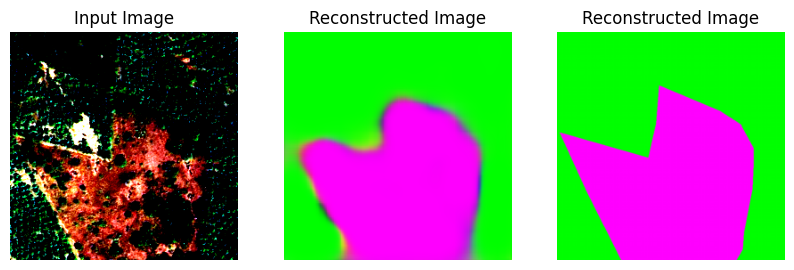

In [ ]:
output_image(loaded_model, train_loader, device)